In [66]:
import geopandas as gpd
from odc.geo import XY, BoundingBox
from odc.geo.gridspec import GridSpec
import shapely

In [2]:
# Create a gridspec for Vietnam
vietnam_epsg = "EPSG:3405"
vietnam = GridSpec(crs=vietnam_epsg, tile_shape=(2000,2000), resolution=25, origin=XY(100, 5))

In [3]:
# Select relevant tiles and convert to Geopandas
bounds = BoundingBox(104, 5, 110, 25, crs="EPSG:4326").to_crs(vietnam_epsg)
geom = vietnam.geojson(bbox=bounds)
tiles_projected = gpd.GeoDataFrame.from_features(geom, crs="EPSG:4326").to_crs(vietnam_epsg)

In [4]:
# Get the Natural Earth country boundaries dataset
ne_url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
natural_earth_10m = gpd.read_file(ne_url)

In [125]:
# Prepare a dataset that contains coastlines with a 15 km buffer
vietnam = natural_earth_10m[natural_earth_10m["ADMIN"] == "Vietnam"].to_crs(vietnam_epsg)
asia = natural_earth_10m[natural_earth_10m["CONTINENT"] == "Asia"]
asia_coast = asia.dissolve().boundary.to_crs(vietnam_epsg)
asia_coast_buffer = asia_coast.buffer(15000)

aoi = vietnam.buffer(20000).clip(asia_coast_buffer.set_crs(vietnam_epsg))

In [130]:
# Clean up holes in polygons made from buffering island lines
def remove_interiors(poly):
    geoms = []
    for geom in poly.geoms:
        if geom.interiors:
            geoms.append(shapely.Polygon(list(geom.exterior.coords)))
        else:
            geoms.append(geom)
    return shapely.MultiPolygon(geoms)

final_aoi = aoi.apply(remove_interiors).set_crs(epsg=vietnam_epsg.split(":")[1])

<Axes: >

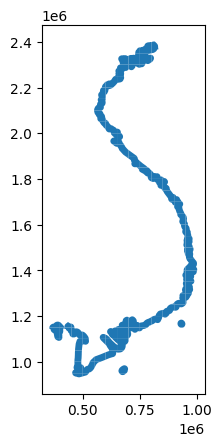

In [131]:
# Clip the tiles to the Vietnam coasline extent
vietnam_coastal_tiles_clipped = tiles_projected.clip(final_aoi)
vietnam_coastal_tiles_clipped.plot()

In [136]:
vietnam_coastal_tiles_clipped.to_crs("EPSG:4326").to_file("../data/raw/vietnam_coast_tiles.geojson", driver='GeoJSON')

<Axes: >

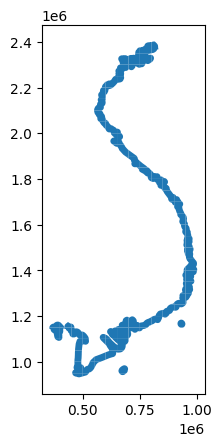

In [133]:
vietnam_coastal_tiles_clipped.plot()